In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models.func import *

# Generate dummy function

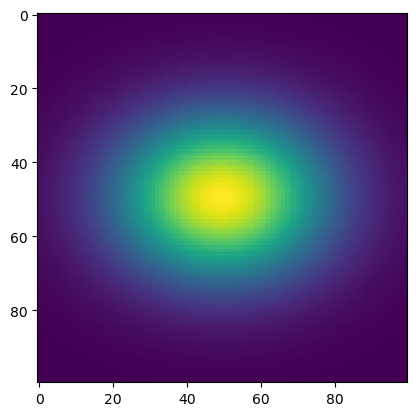

In [2]:
def f(a,b):
    return np.exp(-(0.7*(a-2.5))**2) * np.exp(-(0.9*(b-2.5))**2)

def g(a,b):
    return 10 - np.sqrt(a*a+b*b)

x1 = np.linspace(0, 5, 100)
x2 = np.linspace(0, 5, 100)

X, Y = np.meshgrid(x1, x2)
Z = f(X, Y)

plt.imshow(Z)

# Generate data according to the function

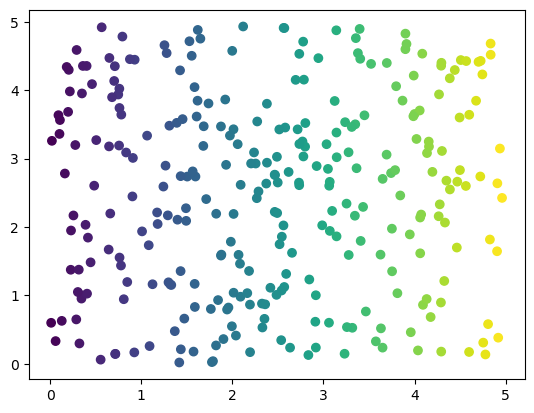

In [3]:
x1 = np.random.random(300) * 5
x2 = np.random.random(300) * 5

# this one is too complex for now
# y = f(x1, x2) # error term?
y = (x1)/10


plt.scatter(x1, x2, c=y);

### Might not be enough datapoints...

# Create perceptron

In [4]:
# activation function and its derivative
def sigm(x):
    return 1/(1+np.exp(-x))

def dsigm(x):
    return np.exp(-x)/(1+np.exp(-x))**2

def relu(x):
    return (x > 0) * x

def drelu(x):
    return (x > 0)

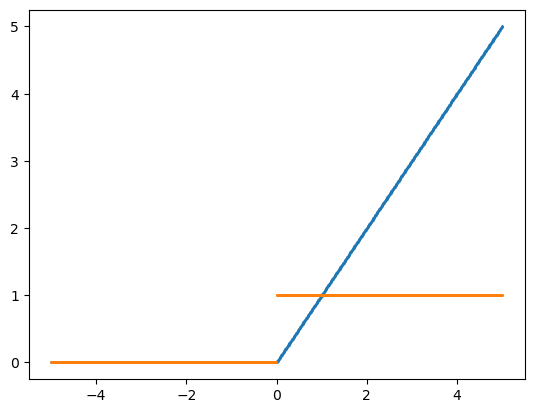

In [5]:
x = np.linspace(-5,5,1000)
plt.scatter(x, relu(x), s=1);
plt.scatter(x, relu_dx(x), s=1);

In [6]:
class Perceptron:
    """ Simple perceptron for regression. Most things are hardcoded """
    
    def __init__(self):
        # initialize weights
        self.w1, self.w2 = np.random.randn(2)
    
    def eval(self, x1, x2):
        return self._forward_pass(x1, x2)
    
    # fpass for a single point
    def _forward_pass(self, x1, x2, actf=sigm):
        return actf(self.w1 * x1 + self.w2 * x2)

    # derivative of the forward pass
    def _df(self, x1, x2, actf=dsigm):
        return actf(self.w1 * x1 + self.w2 * x2)

    # simple square error
    def loss(self, x1, x2, y_true):
        return np.sum((self._forward_pass(x1, x2) - y_true)**2) 

    # learn over the set (X1,X2, y)
    # iterate over the set and update weights for every forward pass, scaling gradient by lrate
    def learn(self, X1, X2, Y, lrate=0.01):
        for x1, x2, y in zip(X1, X2, Y):
            fpass = self._forward_pass(x1, x2)
            gradient = 2 * (fpass - y) * self._df(x1, x2)
            gradient_w1 = gradient * x1
            gradient_w2 = gradient * x2
            # update weights...
            self.w1 -= lrate * gradient_w1
            self.w2 -= lrate * gradient_w2

Loss before training: 70.06802989013693


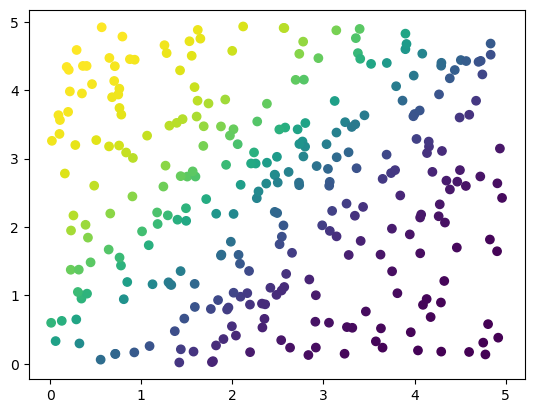

In [7]:
perceptron = Perceptron()

print(f"Loss before training: {perceptron.loss(x1, x2, y)}")
y_pred = perceptron.eval(x1, x2)
plt.scatter(x1, x2, c=y_pred)

Loss now: 10.453084888632013


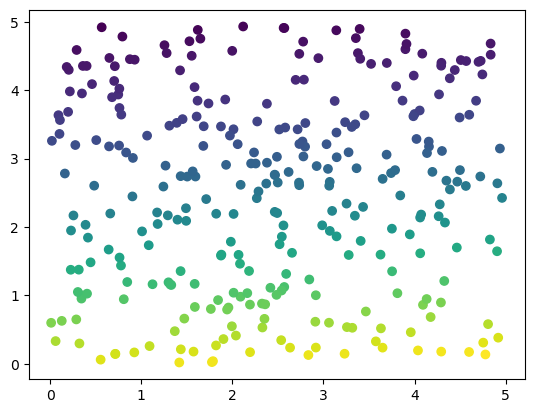

In [8]:
iters = 100
for i in range(iters):
    perceptron.learn(x1, x2, y)
y_pred = perceptron.eval(x1, x2)
plt.scatter(x1, x2, c=y_pred)
print(f"Loss now: {perceptron.loss(x1, x2, y)}")

In [9]:
perceptron.w2

-0.40585789213436335

### Somethings happening...

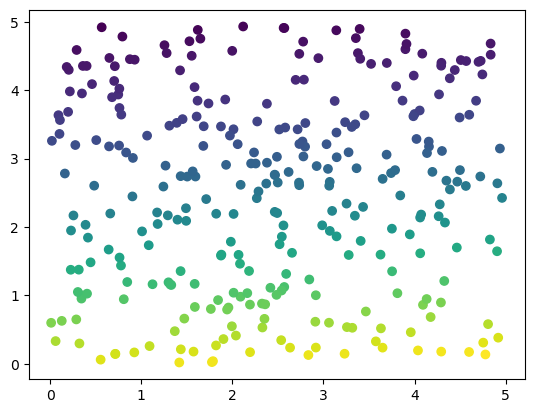

In [10]:
y_pred = perceptron.eval(x1, x2)
plt.scatter(x1, x2, c=y_pred)

In [11]:
class PerceptronRegressor:
    """ Vectorized perceptron for regression. Most things are hardcoded """
    
    def __init__(self, n_inputs, actf, actfd):
        # initialize weights
        self.W = np.random.randn(n_inputs)
        self.actf = actf
        self.actfd = actfd
    
    def eval(self, x):
        return self._forward_pass(x)
    
    # fpass for a single point
    def _forward_pass(self, x):
        return self.actf(np.dot(x, self.W))

    # derivative of the forward pass
    def _df(self, x):
        return self.actfd(np.dot(x, self.W))

    # simple square error
    def loss(self, x, y_true):
        return np.sum((self._forward_pass(x) - y_true)**2) 

    # learn over the set (X1,X2, y)
    # iterate over the set and update weights for every forward pass, scaling gradient by lrate
    def _learn(self, X, Y, lrate=0.01):
        for x, y in zip(X, Y):
            fpass = self._forward_pass(x)
            gradient = 2 * (fpass - y) * self._df(x) * x
#             print(gradient)
            # update weights...
            self.W -= lrate * gradient
        
    def train(self, X, Y, iters=100, lrate=0.01):
        for i in range(iters):
            self._learn(X, Y, lrate)
#             print(f"Step {i}, loss {self.loss(X, Y)}, weights {self.W}")
            

class PerceptronClassifier(PerceptronRegressor):
    def __init__(self, n_inputs):
        super().__init__(n_inputs, sigm, dsigm)
    
    def loss(self, x, y_true):
        y_pred = self._forward_pass(x)
        nll = - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)
        return np.sum(nll)
    
    def _learn(self, X, Y, lrate=0.01):
        for x, y in zip(X, Y):
            y_pred = self._forward_pass(x)
            nll_gradient = -y/y_pred + (1-y)/(1-y_pred)
            gradient = nll_gradient * self._df(x) * x
#             print(gradient)
            self.W -= lrate * gradient

In [12]:
perceptron = PerceptronRegressor(3, relu, drelu)
perceptron.W
X = np.stack([x1, x2, np.ones(x1.shape)], axis=1)
print(perceptron.loss(X, y))

23.36488940814976


# Let's try something simpler - pure linear regression on one x

In [13]:
y = 13.5*x1 + 3.123*x2 + 4.12
X = np.stack([x1, x2, np.ones(x1.shape)],axis=1)

In [14]:
# perc = PerceptronV(3, lambda x: x, lambda x: 1)
perc = PerceptronRegressor(3, relu, drelu)

print(f"Loss before training: {perc.loss(X, y)}")
perc.train(X, y, iters=10)
print(f"Loss after training: {perc.loss(X, y)}")
print(f"Weights after training: {perc.W}")

Loss before training: 712593.5144703125
Loss after training: 1.2575265436619198e-05
Weights after training: [13.50009866  3.1231009   4.11950548]


## ReLU works if coeffs are non-negative

# Works :) good

# Classification + sigmoid act.

## Simplest possible case

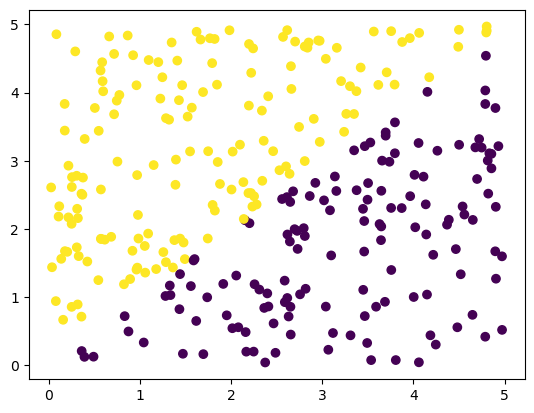

In [16]:
# y_c = ((x1 < 2.5).astype(float) != (x2 < 2.5)).astype(float)
# y_c = (x1 < 2 + x2 < 2).astype(float)
y_c = (x1 < x2).astype(float)
plt.scatter(x1, x2, c=y_c);

In [17]:
perc = PerceptronClassifier(3)

print(f"Loss before training: {perc.loss(X, y_c)}")
perc.train(X, y_c, iters=200)
print(f"Loss after training: {perc.loss(X, y_c)}")
print(f"Weights after training: {perc.W}")

Loss before training: 480.6303840986015
Loss after training: 15.057498892017428
Weights after training: [-6.65414488  6.85837985 -0.47824825]


In [18]:
y_pred = perc.eval(X)

[-6.65414488  6.85837985 -0.47824825]


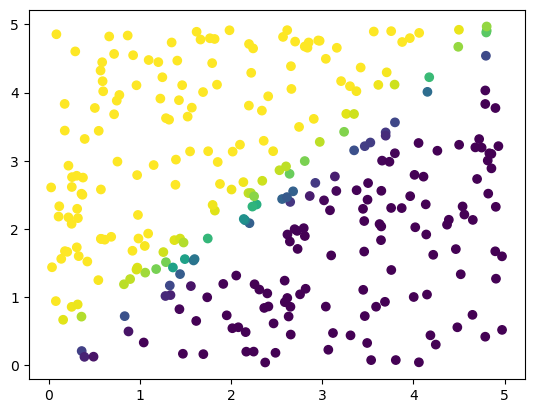

In [19]:
print(perc.W)
plt.scatter(X[:,0], X[:,1], c=y_pred);

# AUC and prediction scores

Datapoints 300, threshold 0.1, acc: 0.9266666666666666, TP: 160, FP: 22, TN: 118, FN: 0
Datapoints 300, threshold 0.3, acc: 0.9766666666666667, TP: 160, FP: 7, TN: 133, FN: 0
Datapoints 300, threshold 0.5, acc: 1.0, TP: 160, FP: 0, TN: 140, FN: 0
Datapoints 300, threshold 0.7, acc: 0.9766666666666667, TP: 153, FP: 0, TN: 140, FN: 7
Datapoints 300, threshold 0.9, acc: 0.9266666666666666, TP: 138, FP: 0, TN: 140, FN: 22


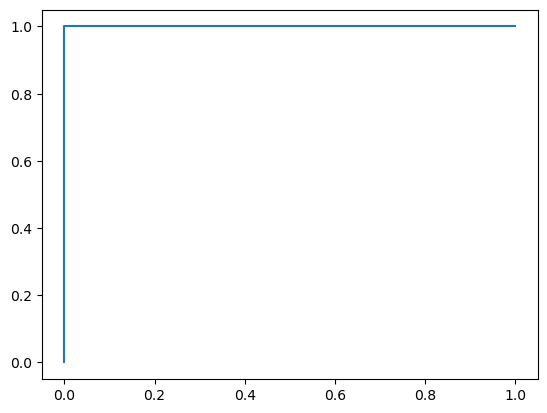

In [20]:
def get_roc_data(y_pred, y_true, res=100):
    y_pred = y_pred.reshape(-1)
    thresh_range = np.linspace(0, 1, res)
    tpr = []
    fpr = []

    for th in thresh_range:
        y_pred_c = (y_pred > th).astype(int)
        tp = np.sum((y_pred_c == 1) & (y_true == 1))
        tn = np.sum((y_pred_c == 0) & (y_true == 0))
        fp = np.sum((y_pred_c == 1) & (y_true == 0))
        fn = np.sum((y_pred_c == 0) & (y_true == 1))
        tpr.append(tp/(tp + fn))
        fpr.append(fp/(fp + tn))
    return tpr, fpr
    
def print_scores(y_pred, y_true, threshold=0.5):
    y_pred = y_pred.reshape(-1)
    y_pred_c = (y_pred > threshold).astype(int)
    tp = np.sum((y_pred_c == 1) & (y_true == 1))
    tn = np.sum((y_pred_c == 0) & (y_true == 0))
    fp = np.sum((y_pred_c == 1) & (y_true == 0))
    fn = np.sum((y_pred_c == 0) & (y_true == 1))
    print(f"Datapoints {len(y_true)}, threshold {th}, acc: {(tp + tn)/(tp + tn + fp + fn)}, TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")


# plot ROC curve
tpr, fpr = get_roc_data(y_pred, y_c)
plt.plot(fpr, tpr);
    
# check some thresholds individually
for th in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print_scores(y_pred, y_c, th)

# Hooray!!!

# Multi-layered version

# Compare LogReg and NN on a couple of example datasets

In [2]:
x1 = np.random.random(1000)
x2 = np.random.random(1000)
# y = x1**2 - 2*x1 + 3

y = ((x1-0.5)**2 + (x2-0.5)**2 < 0.1).astype(int)
# y = ((x1 > 0.5) != (x2 > 0.5)).astype(int) # xor example
X = np.stack([x1, x2, np.ones(1000)], axis=1)
# Y = (X[:,0] ** 2 + X[:,1] ** 2 < 0.5).astype(int)
# Y = (X[:, 0] > 2*X[:, 1] + 0.3).astype(int)

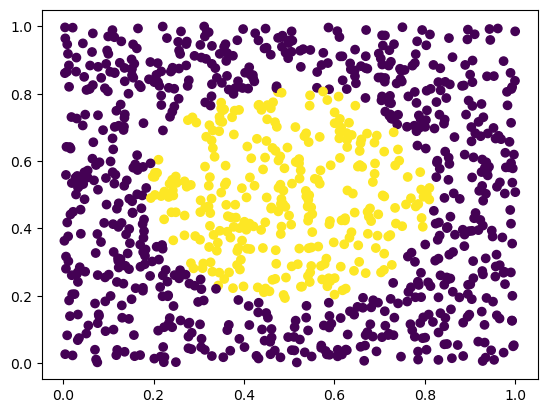

In [3]:
plt.scatter(x1, x2, c=y);

### Compare element-wise, batch and stochastic learning

In [23]:
from models.mlp import MLP
from copy import deepcopy

single_trained_nn = MLP([3, 3, 2, 1])
batch_trained_nn = MLP([3, 3, 2, 1])
stochastic_trained_nn = MLP([3, 3, 2, 1])
batch_trained_nn.W = deepcopy(single_trained_nn.W)
stochastic_trained_nn.W = deepcopy(single_trained_nn.W)

print("Single-datapoint stochastic updates:")
print(f"Loss before training: {single_trained_nn.loss(X, y)}")
single_trained_nn.train_stochastic_batch(X, y, lrate=0.01, iters=500_000, batch_size=1)
print(f"Loss after training: {single_trained_nn.loss(X, y)}")

batch_size = 10
print(f"Batch updates, size {batch_size}:")
print(f"Loss before training: {batch_trained_nn.loss(X, y)}")
batch_trained_nn.train_batch(X, y, lrate=0.01, iters=50_000, batch_size=batch_size)
print(f"Loss after training: {batch_trained_nn.loss(X, y)}")

stochastic_batch_size = 10
print(f"Stochastic batch updates, size {stochastic_batch_size}:")
print(f"Loss before training: {stochastic_trained_nn.loss(X, y)}")
stochastic_trained_nn.train_stochastic_batch(X, y, lrate=0.01, iters=50_000, batch_size=stochastic_batch_size)
print(f"Loss after training: {stochastic_trained_nn.loss(X, y)}")



Single-datapoint stochastic updates:
Loss before training: 643.7898900698013
Loss after training: 426.7213510318993
Batch updates, size 10:
Loss before training: 643.7898900698013
Loss after training: 605.0520472156119
Stochastic batch updates, size 10:
Loss before training: 643.7898900698013
Loss after training: 604.9756598780344


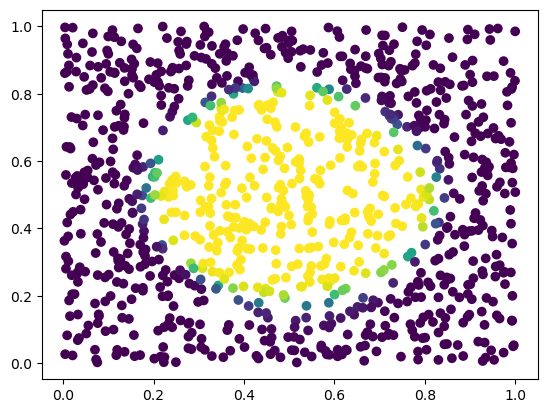

In [18]:
y_pred = stochastic_trained_nn.predict(X)
plt.scatter(X[:,0], X[:,1], c=y_pred);

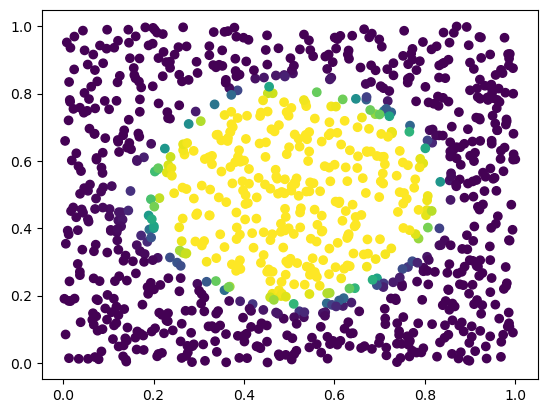

In [53]:
y_pred_batch = mlp2.predict(X)
plt.scatter(X[:,0], X[:,1], c=y_pred_batch);

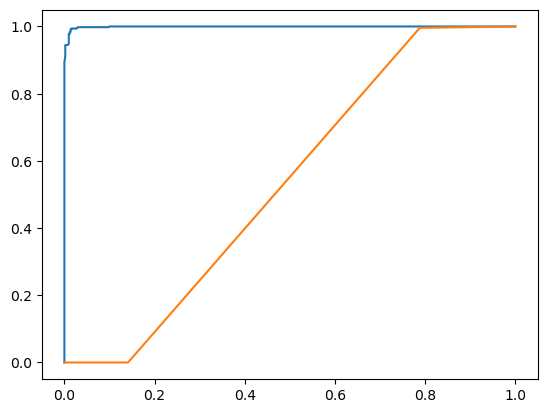

In [162]:
perc_tpr, perc_fpr = get_roc_data(y_pred_pc, y)
nn_tpr, nn_fpr = get_roc_data(y_pred, y)
plt.plot(nn_fpr, nn_tpr);
plt.plot(perc_fpr, perc_tpr);

In [15]:
print("scores for perceptron")
for th in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print_scores(y_pred_pc, y, threshold=th)
print("scores for NN")
for th in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print_scores(y_pred, y, threshold=th)

scores for perceptron


NameError: name 'print_scores' is not defined

#  you need 3-3-2-1 network, apparently

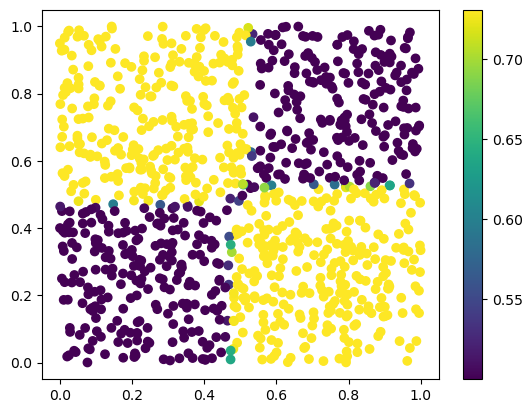

In [117]:
def compute_xor(x1, x2, ones, cutoff=0.5):
    n1 = sigm(50*(x1 - cutoff*ones))
    n2 = sigm(50*(x2 - cutoff*ones))
    n3 = sigm(50*n1 - 50*n2 - 10)
    n4 = sigm(50*n2 - 50*n1 - 10)
    n5 = sigm(n3 + n4)
    return n5

xory = compute_xor(X[:,0], X[:,1], X[:,2])
plt.scatter(X[:,0], X[:,1], c=xory, label=xory);
plt.colorbar();

In [412]:
x1

array([9.22771598e-02, 6.46622092e-01, 5.33827592e-01, 1.02987493e-01,
       7.08226422e-01, 4.88253203e-01, 5.02943440e-01, 9.60707817e-01,
       7.67217237e-01, 2.96823404e-01, 9.95618981e-02, 9.35388285e-01,
       7.70594999e-01, 1.54179199e-01, 8.42971391e-01, 1.79685110e-01,
       6.97096721e-01, 5.51412642e-01, 2.63285945e-01, 6.82295294e-01,
       1.64618493e-01, 8.18263158e-01, 9.56700899e-01, 7.33188381e-01,
       6.18707545e-01, 5.94737211e-01, 8.91163297e-01, 3.94471781e-01,
       7.56977571e-01, 5.42363900e-01, 7.16781349e-01, 2.02606064e-01,
       9.72670563e-01, 5.77189744e-01, 8.87166999e-01, 9.76989491e-01,
       1.67625673e-01, 7.11968282e-01, 8.31246376e-01, 8.46198982e-01,
       4.47479680e-01, 9.22576581e-01, 2.10224566e-01, 8.71108148e-01,
       4.10162705e-01, 6.91585370e-01, 4.35540300e-01, 4.82411506e-01,
       2.00598958e-01, 1.96281868e-01, 8.61165658e-01, 7.09323693e-01,
       6.21029355e-01, 5.10290435e-01, 4.62172738e-01, 3.76594760e-01,
      